# 1. Introduction

Treves Li

UC Berkeley

2025-12-07

Create 3D digital twin of hillslope and colluvium at the Big C.

# 2. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path

# Set root path
import sys
root_path = Path.cwd().parents[0]
sys.path.append(str(root_path / "code"))

# GIS helpers
from common_utils.gis_helpers import em_inv2paraview, extract_elev_from_dem, filter_pred_intersect, format_csv2pointcloud
from common_utils.emagpy_helpers import plot_inv_em_xsection
from viz_helpers import voxelise_csv, plot_3d_voxel, plot_curtain_slice

# Plotting defaults
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

Import EM predictions df and DEM tif.

In [2]:
df = pd.read_csv(root_path / "data" / "processed" / "20251123_em_processed" / "1437_processed_inv_doi.csv")
dem_path = root_path / "data" / "raw" / "bigc_dem.tif"

# 3. Interpolate EM Points

1. Create a 2D grid covering the XY extent
2. For each fixed depth, interpolate horizontally
3. Convert depth → elevation

In [3]:
def em_inv2paraview(df, value_name="resistivity"):
    """
    Convert a wide-format EM dataframe into a ParaView-ready 3D point cloud by
    reshaping layer EC values and assigning midpoint depths to each layer.

    Parameters:
        df (pd.DataFrame): Survey dataframe with columns:
            - 'x', 'y'
            - 'layerX' (EC values in mS/m)
            - 'depthX' (cumulative depth values in meters)
        value_name (str): Name assigned to the resistivity output column.

    Returns:
        pd.DataFrame: Long-format point cloud with columns:
            ['x', 'y', 'z', value_name]
    """

    # Identify layer and depth columns
    layer_cols = sorted([c for c in df.columns if c.startswith("layer")])
    depth_cols = sorted([c for c in df.columns if c.startswith("depth")])

    n_layers = len(layer_cols)
    n_depths = len(depth_cols)

    if n_layers == 0:
        raise ValueError("No layerX columns found.")

    # Compute layer midpoint depths
    # Start at surface (depth=0)
    depth_vals = [0.0] + [df.iloc[0][dcol] for dcol in depth_cols]

    # Handle case where n_layers = n_depths + 1
    if n_layers == n_depths + 1:
        last_interval = depth_vals[-1] - depth_vals[-2]
        depth_vals.append(depth_vals[-1] + last_interval)

    # Midpoint depths for each layer
    mid_depths = [(depth_vals[i] + depth_vals[i+1])/2 for i in range(n_layers)]

    depth_map = {layer_cols[i]: mid_depths[i] for i in range(n_layers)}

    # Melt layer columns to long format
    df_long = df.melt(
        id_vars=["x", "y"],
        value_vars=layer_cols,
        var_name="Layer_Name",
        value_name=value_name,
    )
    df_long.dropna(subset=[value_name], inplace=True)

    # Convert EC to resistivity
    df_long[value_name] = 1000.0 / df_long[value_name]

    # Assign z based on layer depth
    df_long["z"] = df_long["Layer_Name"].map(depth_map)

    # Final output
    df_out = df_long[["x", "y", "z", value_name]].copy()
    df_out.reset_index(drop=True, inplace=True)

    return df_out

Justify using "spherical" variogram model.

In [4]:
from pykrige.ok import OrdinaryKriging
import rasterio
import numpy as np
import pandas as pd
from rasterio.transform import rowcol

def interp_em_inv(df, dem_path=None, value_col="resistivity",
                  dx=1.0, dy=1.0, variogram_model="spherical", nlags=6):
    """
    2D per-layer interpolation of EM data using ordinary kriging, optionally clipped to DEM.

    Parameters:
        df (pd.DataFrame): columns ['x','y','z', value_col] (z = depth)
        dem_path (str or Path, optional): DEM path for masking. If None, no DEM clipping.
        dx, dy (float): grid spacing in X and Y
        variogram_model (str): 'linear', 'spherical', 'exponential', etc.
        nlags (int): number of variogram lags

    Returns:
        pd.DataFrame: interpolated 3D grid with columns ['x','y','z', value_col]
    """

    # Define horizontal grid
    xmin, xmax = df['x'].min(), df['x'].max()
    ymin, ymax = df['y'].min(), df['y'].max()
    grid_x = np.arange(xmin, xmax + dx, dx)
    grid_y = np.arange(ymin, ymax + dy, dy)
    GX, GY = np.meshgrid(grid_x, grid_y)

    # Load DEM if provided
    if dem_path is not None:
        with rasterio.open(dem_path) as src:
            dem_data = src.read(1)
            dem_transform = src.transform

    # Interpolate per unique depth
    depths = np.unique(df['z'].round(6))  # rounding avoids floating point issues
    out_records = []

    for z_val in depths:
        subset = df[np.isclose(df['z'], z_val)]
        if subset.empty:
            continue

        x = subset['x'].values
        y = subset['y'].values
        val = subset[value_col].values

        # Skip if too few points for Kriging
        if len(val) < 3:
            continue

        # 2D Kriging
        OK = OrdinaryKriging(
            x, y, val,
            variogram_model=variogram_model,
            nlags=nlags,
            verbose=False,
            enable_plotting=False
        )

        V, ss = OK.execute("grid", grid_x, grid_y)

        # DEM mask
        if dem_path is not None:
            rows, cols = rowcol(dem_transform, GX, GY)
            rows = np.clip(rows, 0, src.height - 1)
            cols = np.clip(cols, 0, src.width - 1)
            dem_vals = dem_data[rows, cols]
            mask_above = z_val > dem_vals
            V[mask_above] = np.nan

        # Store results
        out_records.append(
            pd.DataFrame({
                'x': GX.ravel(),
                'y': GY.ravel(),
                'z': np.full(GX.size, z_val),
                value_col: V.ravel()
            })
        )

    # Combine all layers
    out_df = pd.concat(out_records, ignore_index=True)
    return out_df


In [5]:
df_paraview = em_inv2paraview(df, value_name="resistivity")
df_interp = interp_em_inv(df_paraview, dx=0.5, dy=0.5, value_col="resistivity")

Visualise the DEM in Paraview:

    run ParaView
    File → Open → dem.tiff
    Select "GDal Raster Reader", Ok
    Filters → CellDataToPointData → Apply
    Filters → WarpByScalars → ScaleFactor: 1e-5 → Apply


Visualise the EM results in Paraview:

    Import your CFD data into Paraview
    Drag and drop your csv file into Paraview (make sure that the first row of your csv contains the column names e.g “x” , “y”, “z”)
    Use filter “TableToPoints”

Visually setting the resistivity scale from 7 to 230 seems to look good.

# 4. Adjust Points to Topographic Elevation

In [6]:
def extract_elev_from_dem(df, dem_path, x_col='x', y_col='y'):
    """
    Extract elevation from a DEM for each (X, Y) point in the dataframe.
    
    Parameters:
        df (pd.DataFrame): Input dataframe with 'X' and 'Y' columns.
        dem_path (str or Path): Path to the .tif DEM file.
        x_col (str): Name of the X coordinate column in df.
        y_col (str): Name of the Y coordinate column in df.
    
    Returns:
        pd.Series: Elevation values corresponding to input coordinates.
    """
    with rasterio.open(dem_path) as src:
        coords = list(zip(df[x_col].values, df[y_col].values))
        elev = np.array([v[0] for v in src.sample(coords)])
    return pd.Series(elev, index=df.index, name="Elevation")

In [7]:
surface_elevs = extract_elev_from_dem(df_interp, dem_path, x_col='x', y_col='y')
df_interp['z'] = surface_elevs - df_interp['z']

Export data for Paraview.

In [8]:
df_interp.to_csv(root_path / "data" / "processed" / "20251123_em_processed" / "1437_processed_inv_doi_kriged_0pt5.csv", index=False)

# 5. Filter Points by Shapefile

In [9]:
bigc_poly_shape = gpd.read_file(root_path / 'gis' / 'big_c_extent.shp')

# Plot to confirm shapefile shape
# fig, ax = plt.subplots(figsize=(8, 6))
# bigc_poly_shape.boundary.plot(ax=ax, edgecolor="black", facecolor="lightblue", alpha=0.5)
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
# plt.show()

In [10]:
df_interp_cropped = filter_pred_intersect(root_path / 'data' / 'processed' / '20251123_em_processed' / '1437_processed_inv_doi_kriged_0pt5.csv', bigc_poly_shape)
df_interp_cropped.to_csv(root_path / "data" / "processed" / "20251123_em_processed" / "1437_processed_inv_doi_kriged_0pt5_cropped.csv", index=False)

231302 points retained after filtering 'c:\Users\treve\OneDrive\Docs\Education\Masters and PhD\Research\03a_big_c\data\processed\20251123_em_processed\1437_processed_inv_doi_kriged_0pt5.csv'.


# 6. Create Sections / Slices on EM "Cloud"

Curtain slice through data

To plot the slices, we'll use the `plot_curtain_slice` function. This function does:

1. 1D vertical interpolation preserves all measured vertical structure.
2. Controlled *linear* extrapolation: No values extrapolated more than `avg_doi` below the lowest measured point at each horizontal location.
3. Regular `pcolormesh` grid for clean visualisation. `pcolormesh` operates directly on 2D arrays rather than plotting each point individually by passing the entire grid of data to the graphics backend at once.

It generates a vertical curtain slice of resistivity data along a user-defined line by first projecting scattered survey points onto the line and filtering those within a specified tolerance. 
At each horizontal position, it performs 1D vertical interpolation of the resistivity values using `scipy.interpolate.interp1d`, while (optionally) limiting extrapolation to `avg_doi`. 
Interpolated values are assembled into a 2D array (`Z`) corresponding to horizontal distance and elevation (`X`, `Y`), which is then visualiz\sed using `pcolormesh`. This approach produces a smooth/continuous, gridded cross-section.

[Stack Overflow](https://stackoverflow.com/questions/21166679/when-to-use-imshow-over-pcolormesh):
> `imshow` assumes that all data elements in your array are to be rendered at the same size, whereas `pcolormesh`/`pcolor` associates elements of the data array with rectangular elements whose size may vary over the rectangular grid. 

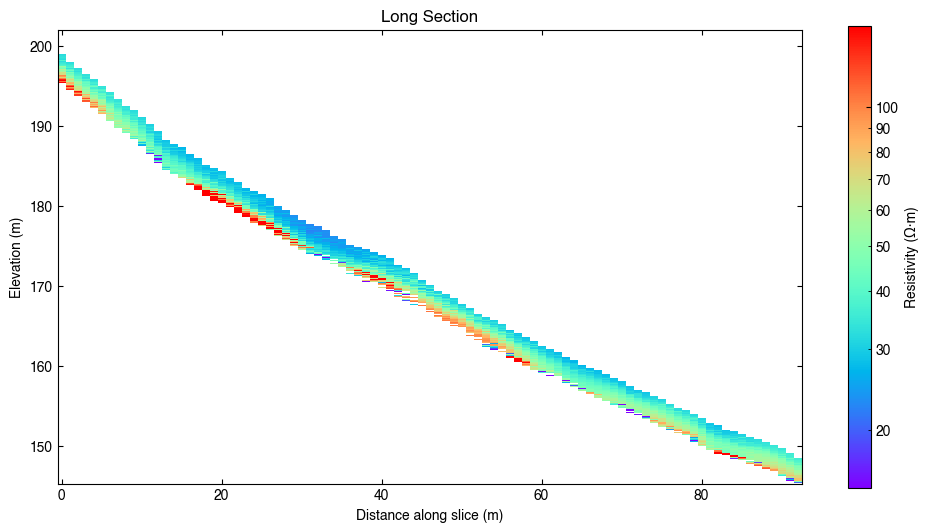

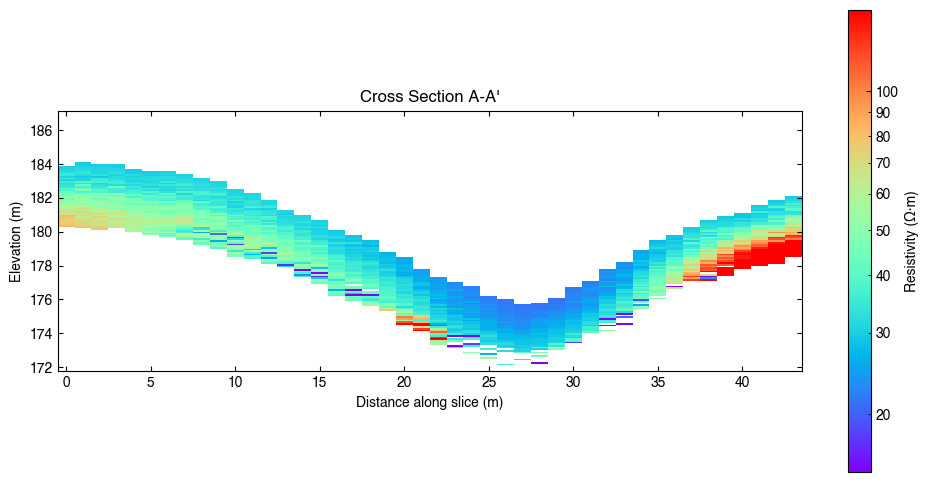

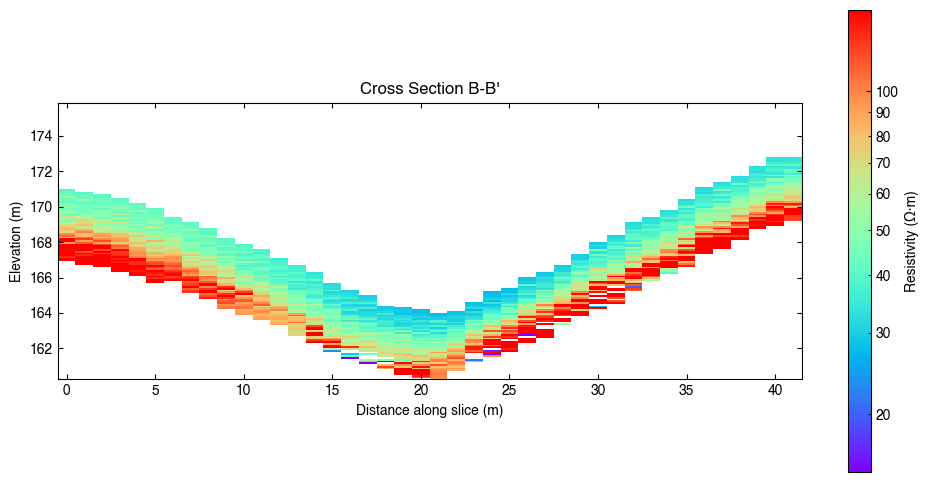

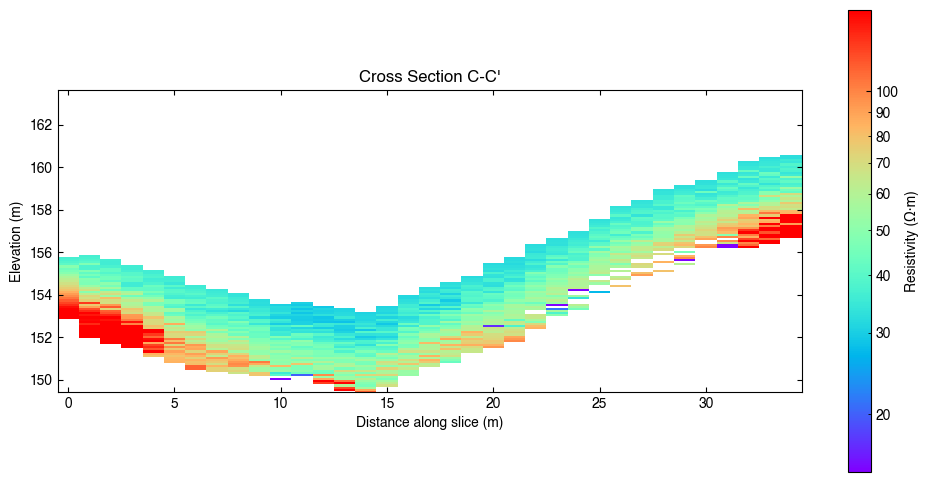

In [57]:
# Limits for resistivity colourbar 
vmin = 15; vmax = 150

# Average DOI
avg_doi = 3.0

# # Long Section
plot_curtain_slice(df_interp_cropped, 
                   x1=565929.0, y1=4192172.6,
                   x2=565844.7, y2=4192092.2,
                   title="Long Section",
                   avg_doi=avg_doi, 
                   vmin=vmin, vmax=vmax)

# # Cross Section 1 (Upper A-A')
plot_curtain_slice(df_interp_cropped, 
                   x1=565876.0, y1=4192162.7,
                   x2=565917.2, y2=4192125.0,
                   title="Cross Section A-A'",
                   avg_doi=avg_doi, 
                   vmin=vmin, vmax=vmax)

# # # Cross Section 2 (Mid B-B')
plot_curtain_slice(df_interp_cropped, 
                   x1=565846.7, y1=4192156.6,
                   x2=565910.9, y2=4192100.3,
                   title="Cross Section B-B'",
                   avg_doi=avg_doi, 
                   vmin=vmin, vmax=vmax)

# # # Cross Section 2 (Lower C-C')
plot_curtain_slice(df_interp_cropped, 
                   x1=565838.5, y1=4192132.9,
                   x2=565894.3, y2=4192082.2,
                   title="Cross Section C-C'",
                   avg_doi=avg_doi, 
                   vmin=vmin, vmax=vmax)